# Clasificación Binaria



**Consigna:** Se dispone de un [dataset](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers) (de dominio público), que contiene información de clientes de una institución financiera, detallando en cada caso, si están en relación vigente o si han dejado de ser clientes.

A partir de estos datos, es de interés poder entrenar un modelo de machine learning (aprendizaje supervisado), capaz de sugerir si un cliente no contemplado en el dataset dejará la institución.

**Prerequisitos:**
1. Asegúrate de subir el archivo `churn.csv` localmente en la sección de archivos antes de ejecutar el siguiente código.

## Leer datos

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('churn.csv')

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('Exited', axis=1), data['Exited'], test_size=0.2, random_state=42)

## Preprocesamiento de datos

**Preprocesamos los datos de la siguiente manera:**
- Eliminamos *columnas irrelevantes*.
  - Las columnas `RowNumber`, `CustomerId` y `Surname` son identificadores únicos y datos que no aportan información relevante para la tarea de predicción. Por lo tanto, podemos eliminarlas y así reducir la dimensionalidad y evitar el sobreajuste.
- Removemos *edades negativas*.
- Reemplazamos *valores nulos* en columnas númericas con la *mediana*.
- Removemos *valores nulos* de columnas categóricas.
- Columnas categóricas se convertirán usando *one-hot encoding*. Esto implica transformar cada categoría en una columna binaria separada.
  - Establecemos el parámetro `handle_unknown='infrequent_if_exist'`, que agrupa automáticamente las categorías menos frecuentes en una misma categoría. Esto permite que el modelo sea más robusto, ya que si aparece una categoría nueva, esta se considerará como parte de la categoría `infrequent`.
  - Establecemos el parámetro `min_frequency=0.1`, para especificar la frecuencia mínima relativa en la que una categoría se considera infrecuente.

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   object 
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   object 
 5   Gender           8000 non-null   object 
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 875.0+ KB


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

def remove_nulls_and_negative_ages(data, y):
  numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
  column_median = data[numeric_columns].median()
  data[numeric_columns] = data[numeric_columns].copy().fillna(column_median)

  data.dropna(inplace=True)
  data = data[data['Age'] >= 0]

  y = y[data.index]
  return data

columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
categorical_features = ['Geography', 'Gender']
numeric_features = [col for col in X_train.columns if col not in columns_to_drop and col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_cols', 'drop', columns_to_drop),
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=0.1), categorical_features)
    ])

pipeline = Pipeline(
    steps=[
        ('remove_nulls_and_negative_ages', FunctionTransformer(remove_nulls_and_negative_ages(X_train, y_train))),
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=0.1), categorical_features)
    ])

## Modelado de los datos

### Descripción de los datos

In [9]:
X_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,9255,15601116,P'an,686,France,Male,32,6,0.00,2,1,1,179093.26
1561,1562,15766374,Leak,632,Germany,Male,42,4,119624.60,2,1,1,195978.86
1670,1671,15716994,Green,559,Spain,Male,24,3,114739.92,1,1,0,85891.02
6087,6088,15730759,Chukwudi,561,France,Female,27,9,135637.00,1,1,0,153080.40
6669,6670,15797900,Chinomso,517,France,Male,56,9,142147.32,1,0,0,39488.04


In [10]:
X_test.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79


In [11]:
X_train.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5012.506875,1.569067e+07,651.647625,38.897750,5.003875,76102.139645,1.531375,0.703500,0.512750,100431.289764
std,2887.649416,7.184743e+04,96.366200,10.518953,2.881822,62461.005757,0.579705,0.456743,0.499869,57518.920431
min,2.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000
25%,2512.750000,1.562822e+07,585.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51364.125000
50%,5014.500000,1.569074e+07,653.000000,37.000000,5.000000,96447.520000,1.000000,1.000000,1.000000,100487.720000
75%,7505.250000,1.575316e+07,719.000000,44.000000,7.000000,127611.332500,2.000000,1.000000,1.000000,149595.842500
max,10000.000000,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000


In [12]:
X_test.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4952.472500,1.569204e+07,646.053500,39.018000,5.048500,78020.88786,1.525500,0.713500,0.524500,98726.040350
std,2884.100313,7.229764e+04,97.689463,10.364332,2.933675,62134.21718,0.589511,0.452239,0.499524,57470.903307
min,1.000000,1.556578e+07,350.000000,18.000000,0.000000,0.00000,1.000000,0.000000,0.000000,11.580000
25%,2463.500000,1.562917e+07,578.000000,32.000000,2.000000,0.00000,1.000000,0.000000,0.000000,49712.365000
50%,4950.500000,1.569085e+07,646.500000,38.000000,5.000000,99796.46000,1.000000,1.000000,1.000000,98511.730000
75%,7488.250000,1.575346e+07,712.250000,44.000000,8.000000,127872.15250,2.000000,1.000000,1.000000,147317.217500
max,9999.000000,1.581569e+07,850.000000,92.000000,10.000000,216109.88000,4.000000,1.000000,1.000000,199992.480000


### Graficar los datos

In [13]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


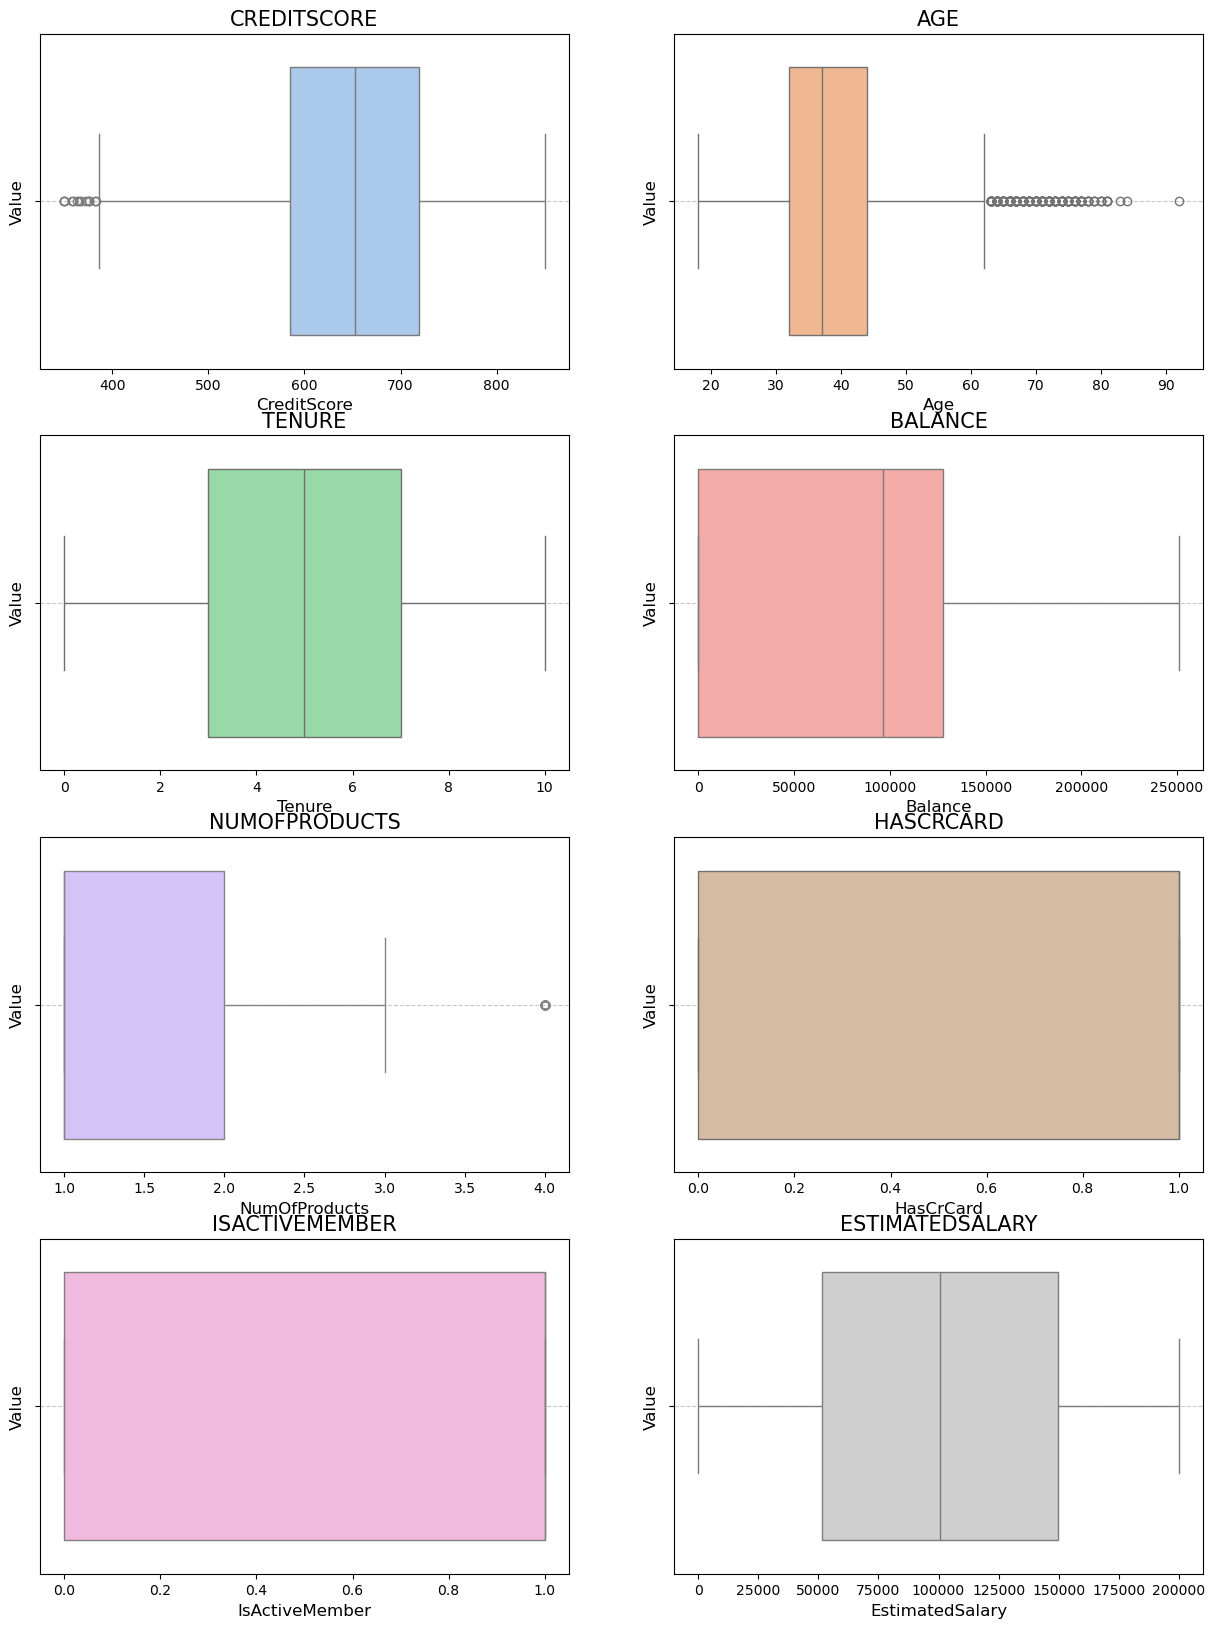

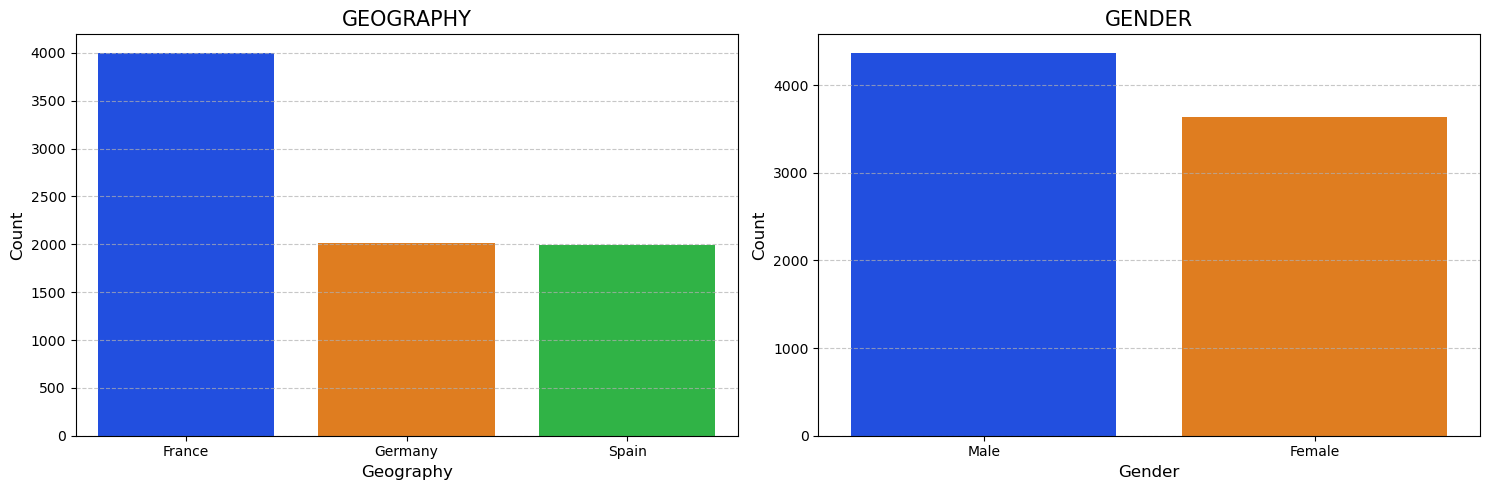

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

continuous_features = X_train.select_dtypes(include=['int64', 'float64']).columns
continuous_features = continuous_features.drop('RowNumber')
continuous_features = continuous_features.drop('CustomerId')

categorical_features = ['Geography', 'Gender']

# Configurar subplots
n_cols_continuous = len(continuous_features)
n_cols_categorical = len(categorical_features)

n_rows_continuous = math.ceil(n_cols_continuous / 2)
n_rows_categorical = math.ceil(n_cols_categorical / 2)

# Configurar subplots para las features continuas
fig, axes = plt.subplots(n_rows_continuous, 2, figsize=(15, 5 * n_rows_continuous))

color_palette = sns.color_palette("pastel")

for i, col in enumerate(continuous_features):
  #Crear un boxplot
  sns.boxplot(data=X_train, x=col, color=color_palette[i % len(color_palette)], ax=axes.flatten()[i])

  # Configurar el título y los nombres de los ejes
  axes.flatten()[i].set_title(col.upper(), fontsize=15)
  axes.flatten()[i].set_xlabel(col, fontsize=12)
  axes.flatten()[i].set_ylabel('Value', fontsize=12)
  axes.flatten()[i].grid(axis='y', linestyle='--', alpha=0.7)

# Configurar subplots para las features categóricas
fix, axes = plt.subplots(n_rows_categorical, 2, figsize=(15, 5 * n_rows_categorical))

cat_color_palette = sns.color_palette("bright")

for i, col in enumerate(categorical_features):
  unique_values = X_train[col].nunique()
  cat_color_palette = cat_color_palette[:unique_values]

  #Crear un boxplot
  sns.countplot(data=X_train, x=col, hue=col, palette=cat_color_palette, ax=axes.flatten()[i])

  # Configurar el título y los nombres de los ejes
  axes.flatten()[i].set_title(col.upper(), fontsize=15)
  axes.flatten()[i].set_xlabel(col, fontsize=12)
  axes.flatten()[i].set_ylabel('Count', fontsize=12)
  axes.flatten()[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Función de evaluación de pipeline


Evaluamos el modelo en el conjunto de prueba usando métricas como `accuracy`, `precision`, `recall` y `F1-score`.

- **Accuracy**: Es la proporción de predicciones correctas sobre el total de predicciones realizadas. Indica cuántas veces el modelo predijo correctamente en general.

- **Precision**: Es la proporción de verdaderos positivos entre todas las instancias que el modelo predijo como positivas. Indica la exactitud del modelo al predecir la clase positiva, es decir, cuántas de las predicciones positivas son realmente correctas.

- **Recall**: Es la proporción de verdaderos positivos entre todas las instancias que realmente son positivas. Mide la capacidad del modelo para identificar correctamente todas las instancias positivas.

- **F1-Score**: Combina precision y recall. Un F1-score alto indica que tanto precision como recall son buenos.

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def evaluate_model(pipeline, X_test, y_test, threshold):
    evaluate_test = evaluate_model_test(pipeline, X_test, y_test, threshold)
    print("-------")
    evaluate_cross_validation = evaluate_model_cross_validation(pipeline, threshold)

def evaluate_model_test(pipeline, X_test, y_test, threshold):
    print("Tests")
    test_predictions = pipeline.predict_proba(X_test)[:,1]
    test_predictions = (test_predictions > threshold).astype(int)
    test_accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

def evaluate_model_cross_validation(pipeline, threshold=0.5, cv=5):
    skf = StratifiedKFold(n_splits=cv)

    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        pipeline.fit(X_fold_train, y_fold_train)

        y_probs = pipeline.predict_proba(X_fold_test)[:, 1]
        y_pred = (y_probs >= threshold).astype(int)

        accuracies.append(accuracy_score(y_fold_test, y_pred))
        precisions.append(precision_score(y_fold_test, y_pred))
        recalls.append(recall_score(y_fold_test, y_pred))
        f1s.append(f1_score(y_fold_test, y_pred))

    print("Cross-Validation")
    print(f"Accuracy: {sum(accuracies) / cv}")
    print(f"Precision: {sum(precisions) / cv}")
    print(f"Recall: {sum(recalls) / cv}")
    print(f"F1 Score: {sum(f1s) / cv}")

### Importancia de las características

In [16]:
def feature_importance(columns, importances):
    feature_importance = pd.DataFrame({'Feature': columns, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance

### Logistic Regression



In [17]:
from sklearn.linear_model import LogisticRegression

LR_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(random_state=16,
                                                             penalty='l1',
                                                             solver='liblinear',
                                                             ))])

LR_pipeline.fit(X_train, y_train)
threshold = 0.2
print('Logistic Regression Results')
evaluate_model(LR_pipeline, X_test, y_test, threshold)

coefficients = LR_pipeline.named_steps['classifier'].coef_[0]
feature_names = LR_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pd.Series(coefficients, index=feature_names).sort_values(ascending=False)

feature_importance(feature_names, importances)

Logistic Regression Results
Tests
Test Accuracy: 0.7015
Precision: 0.3671875
Recall: 0.7175572519083969
F1 Score: 0.4857881136950904
-------
Cross-Validation
Accuracy: 0.688625
Precision: 0.3654901224592748
Recall: 0.6964749054785381
F1 Score: 0.4792278454515073


,Feature,Importance
num__Age,num__CreditScore,7.045262e-02
num__Balance,num__Age,2.475059e-06
num__EstimatedSalary,num__Tenure,3.423002e-07
cat__Geography_Germany,num__Balance,0.000000e+00
num__CreditScore,num__NumOfProducts,-6.115287e-04
num__Tenure,num__HasCrCard,-6.806420e-03
num__HasCrCard,num__IsActiveMember,-3.816175e-02
num__NumOfProducts,num__EstimatedSalary,-1.039921e-01
cat__Geography_Spain,cat__Geography_France,-6.320129e-01
cat__Gender_Female,cat__Geography_Germany,-7.423869e-01


### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

DT_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=16,
                                                                 max_depth=5,
                                                                 min_samples_leaf=1,))])

DT_pipeline.fit(X_train, y_train)

print('Decision Tree Results')
threshold = 0.2
evaluate_model(DT_pipeline, X_test, y_test, threshold)

feature_names = DT_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = DT_pipeline.named_steps['classifier'].feature_importances_

feature_importance(feature_names, importances)

Decision Tree Results
Tests
Test Accuracy: 0.7355
Precision: 0.4095744680851064
Recall: 0.7837150127226463
F1 Score: 0.5379912663755458
-------
Cross-Validation
Accuracy: 0.74975
Precision: 0.43797560363126864
Recall: 0.7657980576766255
F1 Score: 0.5571628047110023


,Feature,Importance
1,num__Age,0.410652
4,num__NumOfProducts,0.331897
6,num__IsActiveMember,0.129971
3,num__Balance,0.057679
9,cat__Geography_Germany,0.053826
7,num__EstimatedSalary,0.014846
0,num__CreditScore,0.000685
12,cat__Gender_Male,0.000443
2,num__Tenure,0.000000
5,num__HasCrCard,0.000000


### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(
                               random_state=16,
                               max_features=5,
                               criterion='entropy',
                               min_samples_leaf=5,
                               ))])

RF_pipeline.fit(X_train, y_train)

print('Random Forest Results')
threshold = 0.3
evaluate_model(RF_pipeline, X_test, y_test, threshold)

feature_names = RF_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = RF_pipeline.named_steps['classifier'].feature_importances_

feature_importance(feature_names, importances)

Random Forest Results
Tests
Test Accuracy: 0.839
Precision: 0.578021978021978
Recall: 0.6692111959287532
F1 Score: 0.6202830188679245
-------
Cross-Validation
Accuracy: 0.8393750000000001
Precision: 0.6006940522176509
Recall: 0.6563106976054564
F1 Score: 0.6268035892491721


,Feature,Importance
1,num__Age,0.277619
4,num__NumOfProducts,0.183048
3,num__Balance,0.133433
7,num__EstimatedSalary,0.107011
0,num__CreditScore,0.098364
2,num__Tenure,0.058826
6,num__IsActiveMember,0.052071
9,cat__Geography_Germany,0.029669
12,cat__Gender_Male,0.013951
11,cat__Gender_Female,0.013528


### Gradient Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

GB_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingClassifier(
                               random_state=16,
                               max_features=5,
                               learning_rate=0.25,
                               criterion='squared_error',
                               min_samples_split=5,
                               max_depth=5,
                               n_iter_no_change=5,
                               ))])

GB_pipeline.fit(X_train, y_train)

print('Gradient Boosting Results')
threshold = 0.3
evaluate_model(GB_pipeline, X_test, y_test, threshold)

feature_names = GB_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = GB_pipeline.named_steps['classifier'].feature_importances_

feature_importance(feature_names, importances)

Gradient Boosting Results
Tests
Test Accuracy: 0.848
Precision: 0.6018306636155606
Recall: 0.6692111959287532
F1 Score: 0.6337349397590362
-------
Cross-Validation
Accuracy: 0.8397500000000001
Precision: 0.6075453337370652
Recall: 0.6246960486322188
F1 Score: 0.6153947762871044


,Feature,Importance
1,num__Age,0.328591
4,num__NumOfProducts,0.275972
3,num__Balance,0.129941
7,num__EstimatedSalary,0.060404
6,num__IsActiveMember,0.054558
0,num__CreditScore,0.051479
9,cat__Geography_Germany,0.043003
2,num__Tenure,0.022396
11,cat__Gender_Female,0.014071
12,cat__Gender_Male,0.005797


## *Super* Modelo

Creamos un "super modelo" que combina los resultados de varios modelos previamente entrenados, usando un sistema de votación ponderado.

Este enfoque permite aprovechar las fortalezas de cada modelo individual, mejorando la precisión global.

In [21]:
from sklearn.ensemble import VotingClassifier
import numpy as np

voting_classifier = VotingClassifier(
    estimators=[
        ('logistic_regression', LR_pipeline),
        ('decision_tree', DT_pipeline),
        ('random_forest', RF_pipeline),
        ('gradient_boosting', GB_pipeline)
    ],
    voting='soft',
    weights=[1, 2, 4, 5]
)

voting_classifier.fit(X_train, y_train)

print('Voting Classifier Results')
threshold = 0.3

evaluate_model(voting_classifier, X_test, y_test, threshold)

feature_names = voting_classifier.estimators_[0].named_steps['preprocessor'].get_feature_names_out()
importances = np.zeros(len(feature_names))

for name, model in voting_classifier.estimators_:
    if hasattr(model, 'feature_importances_'):
        importances += model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances += np.abs(model.coef_[0])

importances /= len(voting_classifier.estimators_)
feature_importance(feature_names, importances)

Voting Classifier Results
Tests
Test Accuracy: 0.851
Precision: 0.6091954022988506
Recall: 0.6743002544529262
F1 Score: 0.640096618357488
-------
Cross-Validation
Accuracy: 0.844125
Precision: 0.6197606020259742
Recall: 0.628336051597598
F1 Score: 0.6234815330264951


,Feature,Importance
12,cat__Gender_Male,0.323344
6,num__IsActiveMember,0.320717
1,num__Age,0.271829
4,num__NumOfProducts,0.223727
8,cat__Geography_France,0.199546
11,cat__Gender_Female,0.192496
10,cat__Geography_Spain,0.161057
3,num__Balance,0.080264
7,num__EstimatedSalary,0.045565
0,num__CreditScore,0.037785


## Predecir nuevos datos

In [22]:
def predict(pipeline, df, threshold=0.3):
    prediction = pipeline.predict_proba(df)
    print(df.to_string())
    result = "Dejará la institución" if prediction[0][1] > threshold else "No dejará la institución"
    print(f"Resultado: {result}")

In [23]:
new_client = {
    'Surname': ['Doe'],
    'CreditScore': [500],
    'Geography': ['Uruguay'],
    'Gender': ['Female'],
    'Age': [30],
    'Tenure': [2],
    'Balance': [4000],
    'NumOfProducts': [1],
    'HasCrCard': [1],
    'IsActiveMember': [1],
    'EstimatedSalary': [50000]
}

new_client_df = pd.DataFrame(new_client)

predict(voting_classifier, new_client_df)

  Surname  CreditScore Geography  Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
0     Doe          500   Uruguay  Female   30       2     4000              1          1               1            50000
Resultado: No dejará la institución


In [24]:
new_client = {
    'Surname': ['Smith'],
    'CreditScore': [5],
    'Geography': ['Germany'],
    'Gender': ['Male'],
    'Age': [80],
    'Tenure': [2],
    'Balance': [4000],
    'NumOfProducts': [1],
    'HasCrCard': [0],
    'IsActiveMember': [0],
    'EstimatedSalary': [50000]
}

new_client_df = pd.DataFrame(new_client)

predict(voting_classifier, new_client_df)

  Surname  CreditScore Geography Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
0   Smith            5   Germany   Male   80       2     4000              1          0               0            50000
Resultado: Dejará la institución


In [25]:
def get_user_input():
    print("Por favor, ingrese los datos del cliente bajo el siguiente formato:")
    print("Surname (str), CreditScore (int), Geography (str), Gender (str), Age (int)")
    print("Tenure (int), Balance (float), NumOfProducts (int), HasCrCard (0-1), IsActiveMember (0-1), EstimatedSalary (float)")

    user_input = input("Ingrese los datos separados por comas: ")
    user_data = user_input.split(',')

    data_dict = {
        'Surname': [user_data[0].strip()],
        'CreditScore': [int(user_data[1].strip())],
        'Geography': [user_data[2].strip()],
        'Gender': [user_data[3].strip()],
        'Age': [int(user_data[4].strip())],
        'Tenure': [int(user_data[5].strip())],
        'Balance': [float(user_data[6].strip())],
        'NumOfProducts': [int(user_data[7].strip())],
        'HasCrCard': [int(user_data[8].strip())],
        'IsActiveMember': [int(user_data[9].strip())],
        'EstimatedSalary': [float(user_data[10].strip())]
    }

    input_df = pd.DataFrame(data_dict)
    return input_df

def predict_churn(pipeline):
    input_df = get_user_input()
    predict(pipeline, input_df)

predict_churn(voting_classifier)

Por favor, ingrese los datos del cliente bajo el siguiente formato:
Surname (str), CreditScore (int), Geography (str), Gender (str), Age (int)
Tenure (int), Balance (float), NumOfProducts (int), HasCrCard (0-1), IsActiveMember (0-1), EstimatedSalary (float)
   Surname  CreditScore Geography  Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
0  pineyro            1   uruguay  female   23       2   2500.0              1          1               1          28000.0
Resultado: Dejará la institución
